# AIE6211 NLP 1st Assignment - Attention is All You Need
### <div style="text-align: right"> 120220224 정원 </div>

In this notebook we will be implementing a (slightly modified version) of the Transformer model from the [Attention is All You Need](https://arxiv.org/abs/1706.03762) paper. All images in this notebook will be taken from the Transformer paper. For more information about the Transformer, [see](https://www.mihaileric.com/posts/transformers-attention-in-disguise/) [these](https://jalammar.github.io/illustrated-transformer/) [three](http://nlp.seas.harvard.edu/2018/04/03/attention.html) articles.

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/transformer1.png?raw=1)

## Introduction

Similar to the Convolutional Sequence-to-Sequence model, the Transformer does not use any recurrence. It also does not use any convolutional layers. Instead the model is entirely made up of linear layers, attention mechanisms and normalization. 

As of January 2020, Transformers are the dominant architecture in NLP and are used to achieve state-of-the-art results for many tasks and it appears as if they will be for the near future. 

The most popular Transformer variant is [BERT](https://arxiv.org/abs/1810.04805) (**B**idirectional **E**ncoder **R**epresentations from **T**ransformers) and pre-trained versions of BERT are commonly used to replace the embedding layers - if not more - in NLP models. 

A common library used when dealing with pre-trained transformers is the [Transformers](https://huggingface.co/transformers/) library, see [here](https://huggingface.co/transformers/pretrained_models.html) for a list of all pre-trained models available.

The differences between the implementation in this notebook and the paper are:
- we use a learned positional encoding instead of a static one
- we use the standard Adam optimizer with a static learning rate instead of one with warm-up and cool-down steps
- we do not use label smoothing

We make all of these changes as they closely follow BERT's set-up and the majority of Transformer variants use a similar set-up.

## Preparing the Data

As always, let's import all the required modules and set the random seeds for reproducability.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

In [4]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

We'll then create our tokenizers as before.

In [5]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [6]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

Our fields are the same as the previous notebook. The model expects data to be fed in with the batch dimension first, so we use `batch_first = True`. 

In [7]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

We then load the Multi30k dataset and build the vocabulary.

In [8]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

In [9]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

#### Check Data length
Train / Validation / Test 각각 몇 개의 데이터로 나누었는지 확인 (데이터 -> 문장)

#### Vocab size
독일어의 경우 7853단어, 영어의 경우 5893단어

In [10]:
len(train_data), len(valid_data), len(test_data)

(29000, 1014, 1000)

In [12]:
# SRC: 독일어 / TRG: 영어
len(SRC.vocab), len(TRG.vocab)

(7853, 5893)

Finally, we define the device and the data iterator.

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Iterator 생성 (Dataloader 역할)
Batch size에 맞춰 source 문장과 target 문장을 묶어준다.

In [14]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device)

## Building the Model

지난 번과 마찬가지로 Encoder에서는 Source 문장인 독일어의 context vector를 찾기 위해 Encoder 구조를 사용한다.
이 때 Transformer의 Encoder는 지난 Encoder처럼 여러 단어 시퀀스를 RNN을 거쳐 하나의 Context vector로 추출하는 대신 Multi-Head attention과 Feed Forward network를 이용해 input sequence와 같은 크기의 context vector들을 추출한다.

### Encoder

$z$ 하나로 context vector를 추출하는 것이 아닌 n개 단어 시퀀스에 해당하는 context vector들을 추출한다.

$Z = (z_1, ... , z_n)$. 

n개의 context vector는 multi-head attention을 통해 전체 단어들을 (문장) 다 학습한 독립적인 context vector이다.

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/transformer-encoder.png?raw=1)

#### Positional Encoding
Transformer는 RNN처럼 순차대로 이동하는 것이 아니라 시퀀스의 순서를 무시하고 연산을 하기 때문에 모델의 입장에서 단어의 위치 정보를 알 수가 없다. 이러한 위치 정보를 추가하기 위해 positional encoding을 진행한다.
Positional embedding layer를 통해 설정한 (현재 colab 코드에서는 100으로 고정) max_length까지의 position을 정한 후 embedding 결과값과 token embedding을 서로 더한 값을 Encoder layer의 input으로 사용하게 된다.
Encoder layer의 경우 그림처럼 Multi-Head attention layer와 feed forward network layer N개를 반복하게 되고 마지막에 context vector $Z$를 decoder단의 input으로 사용하게 된다.

#### Source mask
padding token을 zero로 만들어서 Attention 연산 시에 padding 부분은 고려하지 않도록 masking하는 과정이다.

In [54]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100, is_print=False):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        self.is_print = is_print
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        if self.is_print:
            token_embed = self.tok_embedding(src)
            scales = self.scale
            pos_embed = self.pos_embedding(pos)
            print(f"-- Encoder Block Start --")
            print(f"\nsrc shape: {src.shape}\ntoken embedding vector shape: {token_embed.shape}\ntoken_embedding\n{token_embed}")
            print(f"\nscale shape: {scales.shape}\n{scales}")
            print(f"\npos shape: {pos.shape}\npositional embedding vector shape: {pos_embed.shape}\n")
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
        if self.is_print:
            print(f"\nEncoder output (context vector) shape: {src.shape}\n{src}")
        return src

### Encoder Layer

Multi-Head attention의 Query, Key, Value값을 모두 source 문장으로 사용한다. 
Dropout을 거친 output과 기존 Source 문장을 더해 residual connection을 만든다. 
이후에 layer normalization layer를 통과시킨다. 

Feed-forward Layer를 통과한 후 다시 Dropout, Residual connection, layer normalization을 거쳐 Encoder layer의 output을 추출한다.

In [56]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device, is_print=False):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        self.is_print = is_print
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)

        if self.is_print:
            print(f"\nBefore self-attention shape: {src.shape}")
            print(f"\nAfter self-attention shape: {_src.shape}")
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        

        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        if self.is_print:
            print(f"\nBefore feed-forward layer & layer norm after self-attention shape: {src.shape}")
            print(f"\nAfter feed-forward layer shape: {_src.shape}")    
            
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

### Mutli Head Attention Layer


![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/transformer-attention.png?raw=1)

Query와 key를 행렬곱한 후 (이 때 key는 transpose를 통해 행렬 연산이 가능하도록 shape을 만들어준다.)
Query와 key를 곱한 수치를 작게 만들어주기 위해 $\sqrt{d_k}$로 나눠준 후 softmax를 거치고 다시 value와 행렬곱하면 기존 query(input)의 shape과 같은 output이 만들어진다.

$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$ 

#### Muti-Head
$Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)$
$K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)$
$V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)$
단어의 특징을 나타냈던 embedding 부분인 Hidden dimension을 Head 개수만큼 차원을 쪼갠다.
(ex. hid_dim = 256, n_head = 8이면 
\[Batch_size, sequence_length, hid_dim\] --> \[Batch_size, sequence_length, n_head, hid_dim//n_head\]
\[Batch_size, sequence_length, 256\] --> \[Batch_size, sequence_length, 8, 32\]

In [57]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device, is_print=False):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        self.is_print = is_print
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        if self.is_print:
            print(f"\nQ,K,V shape: {Q.shape}")
            print(f"\nQ*K^T shape: {energy.shape}")
            print(f"\nAfter multiplying Value shape: {x.shape}")
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

### Position-wise Feedforward Layer

hid_dim -> pf_dim
pf_dim -> hid_dim으로 변하는
Linear layer 2개를 통과시킨다. (중간에 dropout존재)

본문에서는 hid_dim = 256, pf_dim = 512 사용

In [58]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

#### Encoder Test -> Shape

In [69]:
INPUT_DIM = len(SRC.vocab)
HID_DIM = 256
ENC_LAYERS = 3
ENC_HEADS = 8
ENC_PF_DIM = 512
ENC_DROPOUT = 0.1

enc_test = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device, is_print=True).cuda()

In [70]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
def test_make_src_mask(src):
    src_mask = (src != SRC_PAD_IDX).unsqueeze(1).unsqueeze(2)
    return src_mask
src_mask = test_make_src_mask(src)

In [72]:
for i, batch in enumerate(test_iterator):
    src = batch.src #src = [src len, batch size] ex) [28, 128]
    encoder_outputs = enc_test(src.cuda(), src_mask.cuda())
    # for testing only single case
    if i == 0:
        break

-- Encoder Block Start --

src shape: torch.Size([128, 10])
token embedding vector shape: torch.Size([128, 10, 256])
token_embedding
tensor([[[ 1.4819, -0.2871,  1.5027,  ...,  0.4072,  0.4348,  0.4493],
         [ 0.7460, -1.3757,  0.8544,  ..., -0.7252,  0.4666,  0.2030],
         [ 0.0133, -0.2203,  0.8252,  ...,  2.0938,  0.9987,  0.1136],
         ...,
         [ 0.0803, -0.3479,  0.4523,  ...,  0.7152, -1.2012, -0.7327],
         [-0.2639,  0.2823, -0.7467,  ..., -0.4670,  1.0296,  0.4881],
         [-0.3972, -0.6312, -0.9701,  ..., -1.7458,  0.1787,  0.0075]],

        [[ 1.4819, -0.2871,  1.5027,  ...,  0.4072,  0.4348,  0.4493],
         [-0.2366, -1.2333,  1.0521,  ...,  1.3232,  0.5376,  0.6963],
         [-0.6388,  0.4042, -1.2651,  ..., -0.1010,  1.8323,  0.9988],
         ...,
         [-2.3636, -1.6703, -0.2582,  ..., -0.3650,  1.4559, -0.4139],
         [-0.2639,  0.2823, -0.7467,  ..., -0.4670,  1.0296,  0.4881],
         [-0.3972, -0.6312, -0.9701,  ..., -1.7458,  0.1

### Decoder


![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/transformer-decoder.png?raw=1)

Decoder 구조는 Encoder와 거의 같다, 대신 Multi-Head attention layer가 2개가 된다.
첫번째 Multi-Head attetntion layer는 target input의 self-attention으로 동작하고,
2번째의 Multi-head attention은 Query만 앞선 attention 값이고, Encoder의 output이 key와 value 값으로 사용된다.

#### Masked Multi-Head attention layer
첫번째 Multi-Head attetntion layer의 경우 Masked Multi-Head attention layer라고 되어있는데
이는 decoder에서 target 단어를 유추할 때 예측하려는 단어의 뒷부분을 미리 보지 않게하기 위해 masking해주는 것을 의미한다. 이를 통해 정답을 미리 보는 것 같은 Cheating 우려를 없앤다.


In [59]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

### Decoder Layer

앞선 Decoder에서 attention과 feed-forward layer 연산을 담고있다.

In [20]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

### Seq2Seq

The source mask shape: **_[batch size, n heads, seq len, seq len]_**.

The target mask for a target with 5 tokens:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

If the last two tokens were `<pad>` tokens the mask would look like:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$


In [61]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device, is_print=False):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        self.is_print = is_print
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        if self.is_print:
            print("-- Seq2Seq --")
            print(f"\nSource mask shape: {src_mask.shape}\n{src_mask}")
            print(f"\nTarget mask shape: {trg_mask.shape}\n{trg_mask}")
            print(f"\nSource sentence shape: {src.shape}")
            print(f"\nAfter Encoder Source sentence shape: {enc_src.shape}")
            print(f"\nTarget sentence shape: {trg.shape}")
            print(f"\nFinal Output shape: {output.shape}\n{output}")
        
        return output, attention

## Training the Seq2Seq Model

We can now define our encoder and decoders. This model is significantly smaller than Transformers used in research today, but is able to be run on a single GPU quickly.

In [62]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

Then, use them to define our whole sequence-to-sequence encapsulating model.

In [23]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

Parameter Check
기존 Convolutional sequence-to-sequence model은 37M개, 현재 9M정도

In [24]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,038,341 trainable parameters


Weight initialization

In [25]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [26]:
model.apply(initialize_weights);

Adam optimizer

In [27]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

Cross entropy loss function

In [28]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [29]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

The evaluation loop is the same as the training loop, just without the gradient calculations and parameter updates.

In [30]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

We then define a small function that we can use to tell us how long an epoch takes.

In [31]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we train our actual model. This model is almost 3x faster than the convolutional sequence-to-sequence model and also achieves a lower validation perplexity!

In [34]:
from tqdm.auto import tqdm

In [35]:
N_EPOCHS = 20
CLIP = 1

best_valid_loss = float('inf')

tr_loss = []
va_loss = []

for epoch in tqdm(range(N_EPOCHS)):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), './checkpoint/tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    tr_loss.append(train_loss); va_loss.append(valid_loss)

 10%|██████▊                                                             | 1/10 [00:12<01:50, 12.27s/it]

Epoch: 01 | Time: 0m 11s
	Train Loss: 3.014 | Train PPL:  20.369
	 Val. Loss: 2.430 |  Val. PPL:  11.354


 20%|█████████████▌                                                      | 2/10 [00:24<01:37, 12.16s/it]

Epoch: 02 | Time: 0m 11s
	Train Loss: 2.341 | Train PPL:  10.394
	 Val. Loss: 2.021 |  Val. PPL:   7.543


 30%|████████████████████▍                                               | 3/10 [00:36<01:25, 12.17s/it]

Epoch: 03 | Time: 0m 11s
	Train Loss: 1.951 | Train PPL:   7.035
	 Val. Loss: 1.842 |  Val. PPL:   6.311


 40%|███████████████████████████▏                                        | 4/10 [00:48<01:12, 12.11s/it]

Epoch: 04 | Time: 0m 11s
	Train Loss: 1.684 | Train PPL:   5.388
	 Val. Loss: 1.711 |  Val. PPL:   5.536


 50%|██████████████████████████████████                                  | 5/10 [01:00<01:00, 12.10s/it]

Epoch: 05 | Time: 0m 11s
	Train Loss: 1.484 | Train PPL:   4.412
	 Val. Loss: 1.662 |  Val. PPL:   5.271


 60%|████████████████████████████████████████▊                           | 6/10 [01:12<00:48, 12.10s/it]

Epoch: 06 | Time: 0m 11s
	Train Loss: 1.325 | Train PPL:   3.762
	 Val. Loss: 1.629 |  Val. PPL:   5.098


 70%|███████████████████████████████████████████████▌                    | 7/10 [01:24<00:36, 12.07s/it]

Epoch: 07 | Time: 0m 11s
	Train Loss: 1.195 | Train PPL:   3.304
	 Val. Loss: 1.617 |  Val. PPL:   5.039


 80%|██████████████████████████████████████████████████████▍             | 8/10 [01:36<00:24, 12.10s/it]

Epoch: 08 | Time: 0m 11s
	Train Loss: 1.081 | Train PPL:   2.947
	 Val. Loss: 1.615 |  Val. PPL:   5.029


 90%|█████████████████████████████████████████████████████████████▏      | 9/10 [01:48<00:11, 11.95s/it]

Epoch: 09 | Time: 0m 11s
	Train Loss: 0.985 | Train PPL:   2.677
	 Val. Loss: 1.636 |  Val. PPL:   5.134


100%|███████████████████████████████████████████████████████████████████| 10/10 [02:00<00:00, 12.01s/it]

Epoch: 10 | Time: 0m 11s
	Train Loss: 0.899 | Train PPL:   2.458
	 Val. Loss: 1.659 |  Val. PPL:   5.254


We load our "best" parameters and manage to achieve a better test perplexity than all previous models.

In [37]:
model.load_state_dict(torch.load('./checkpoint/tut6-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.661 | Test PPL:   5.263 |


### Multiple Experiments changing hyperparameters

| Experiments | Batch size | Learning rate | Best Epoch | Val loss | Test loss | BLEU Score |
| --- | --- | --- | --- | -: | -: | -: |
| 1 | 128 | 0.0005 | 8 | **1.615** | **1.661** | **35.94** |
| 2 | 256 | 0.0005 | 8 | 1.645 |1.695 | 35.20 |
| 3 | 512 | 0.0005 | 13 | 1.711 |1.794 | 34.42 |
| 4 | 128 | 0.0001 | 24 | 1.723 |1.804 | 34.74 |
| 5 | 128 | 0.001 | 7 | 1.722 |1.743 | 32.47 |

## Inference

Now we can can translations from our model with the `translate_sentence` function below.

The steps taken are:
- tokenize the source sentence if it has not been tokenized (is a string)
- append the `<sos>` and `<eos>` tokens
- numericalize the source sentence
- convert it to a tensor and add a batch dimension
- create the source sentence mask
- feed the source sentence and mask into the encoder
- create a list to hold the output sentence, initialized with an `<sos>` token
- while we have not hit a maximum length
  - convert the current output sentence prediction into a tensor with a batch dimension
  - create a target sentence mask
  - place the current output, encoder output and both masks into the decoder
  - get next output token prediction from decoder along with attention
  - add prediction to current output sentence prediction
  - break if the prediction was an `<eos>` token
- convert the output sentence from indexes to tokens
- return the output sentence (with the `<sos>` token removed) and the attention from the last layer

In [38]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de_core_news_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

We'll now define a function that displays the attention over the source sentence for each step of the decoding. As this model has 8 heads our model we can view the attention for each of the heads.

In [39]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

First, we'll get an example from the training set.

In [40]:
example_idx = 8

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'frau', 'mit', 'einer', 'großen', 'geldbörse', 'geht', 'an', 'einem', 'tor', 'vorbei', '.']
trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'is', 'walking', 'by', 'a', 'gate', '.']


Our translation looks pretty good, although our model changes *is walking by* to *walks by*. The meaning is still the same.

In [41]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'walking', 'past', 'a', 'gate', '.', '<eos>']


We can see the attention from each head below. Each is certainly different, but it's difficult (perhaps impossible) to reason about what head has actually learned to pay attention to. Some heads pay full attention to "eine" when translating "a", some don't at all, and some do a little. They all seem to follow the similar "downward staircase" pattern and the attention when outputting the last two tokens is equally spread over the final two tokens in the input sentence.

/tmp/ipykernel_34175/3470126203.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
/tmp/ipykernel_34175/3470126203.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


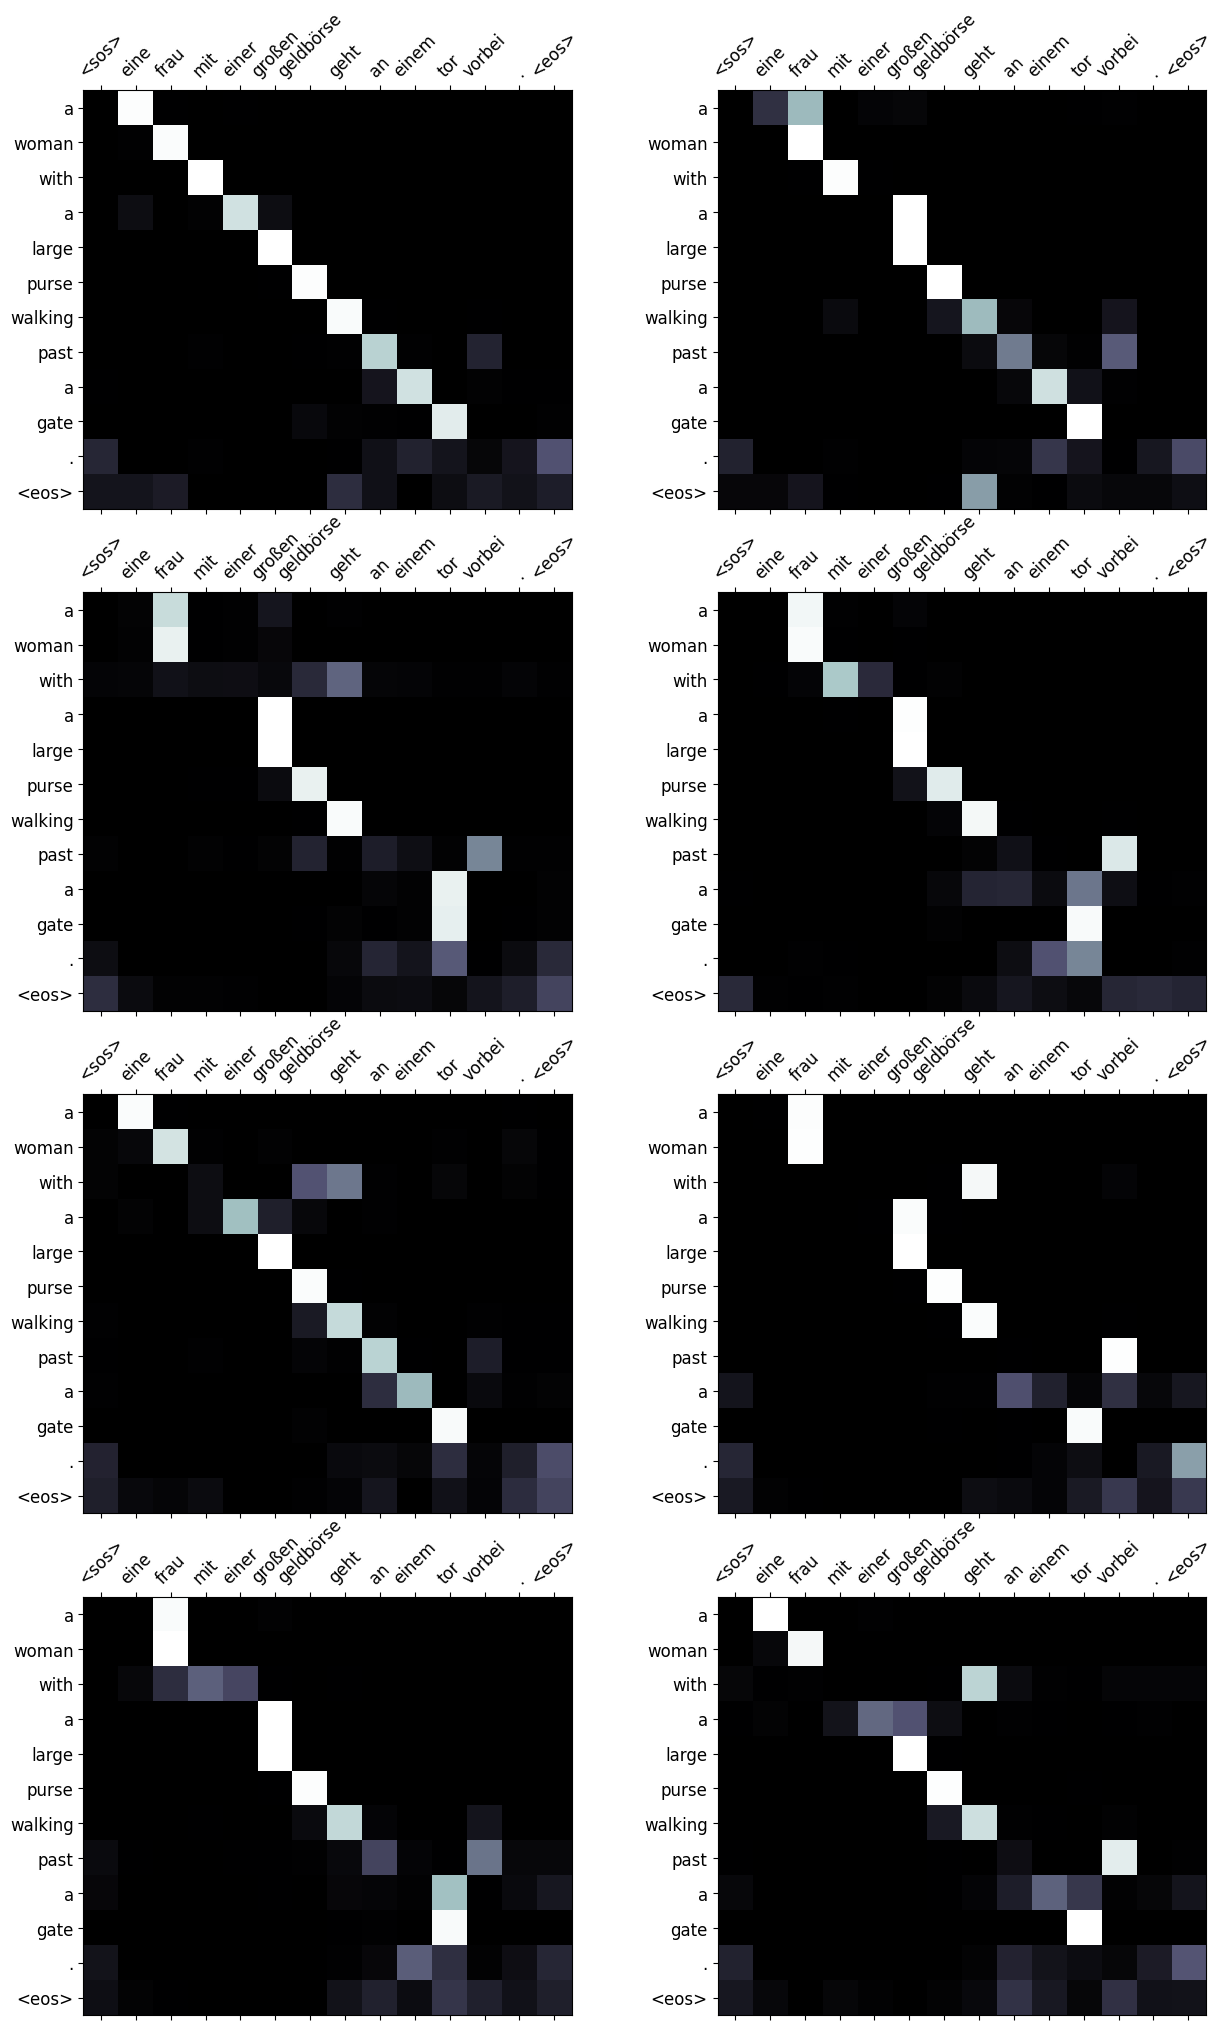

In [42]:
display_attention(src, translation, attention)

Next, let's get an example the model has not been trained on from the validation set.

In [43]:
example_idx = 6

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'brauner', 'hund', 'rennt', 'dem', 'schwarzen', 'hund', 'hinterher', '.']
trg = ['a', 'brown', 'dog', 'is', 'running', 'after', 'the', 'black', 'dog', '.']


The model translates it by switching *is running* to just *runs*, but it is an acceptable swap.

In [44]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'brown', 'dog', 'running', 'after', 'the', 'black', 'dog', '.', '<eos>']


Again, some heads pay full attention to "ein" whilst some pay no attention to it. Again, most of the heads seem to spread their attention over both the period and `<eos>` tokens in the source sentence when outputting the period and `<eos>` sentence in the predicted target sentence, though some seem to pay attention to tokens from near the start of the sentence.

/tmp/ipykernel_34175/3470126203.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
/tmp/ipykernel_34175/3470126203.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


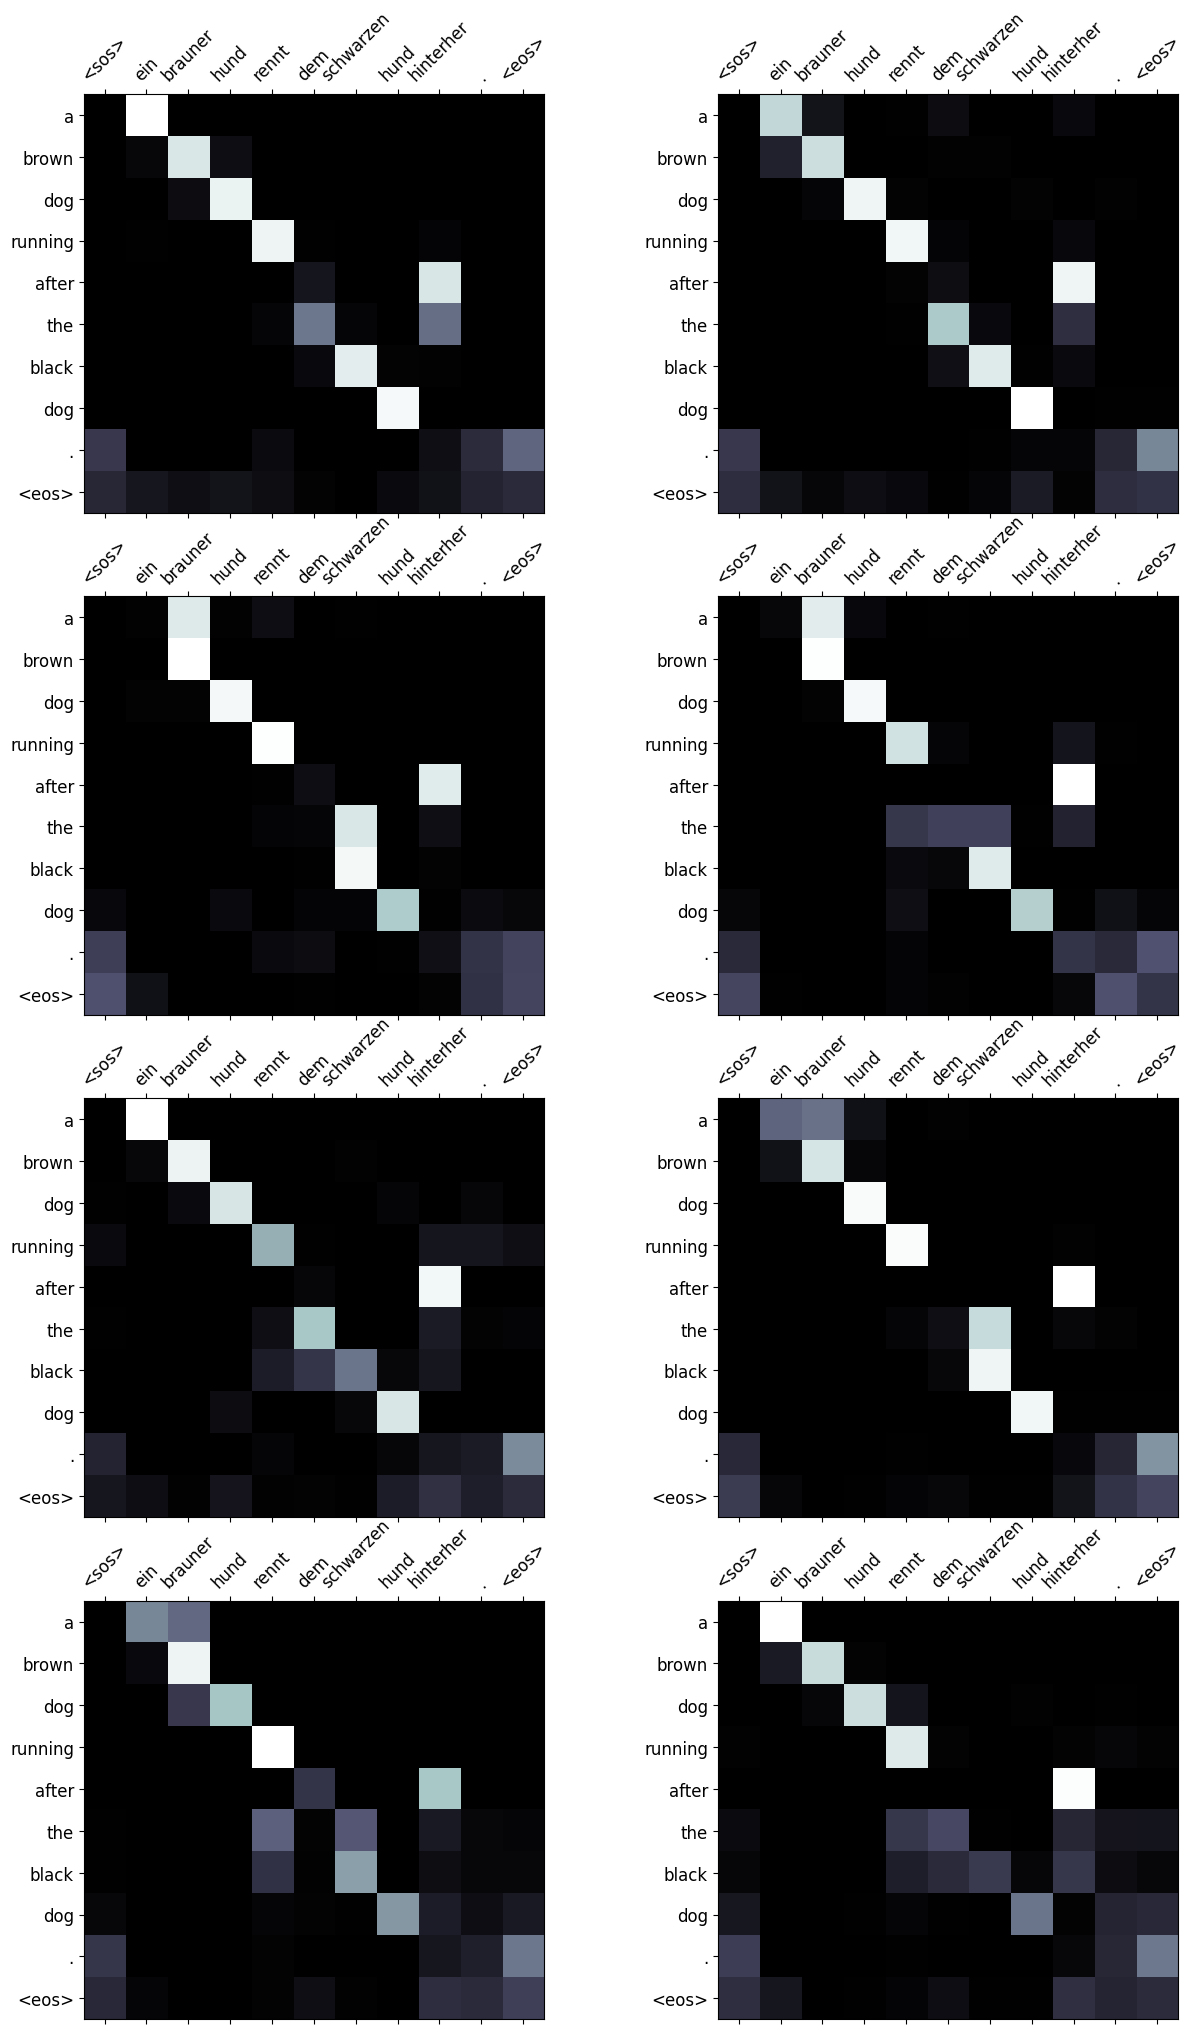

In [45]:
display_attention(src, translation, attention)

Finally, we'll look at an example from the test data.

In [46]:
example_idx = 10

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.']
trg = ['a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.']


A perfect translation!

In [47]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'mother', 'and', 'her', 'little', 'son', 'enjoy', 'a', 'beautiful', 'day', 'outdoors', '.', '<eos>']


/tmp/ipykernel_34175/3470126203.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
/tmp/ipykernel_34175/3470126203.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


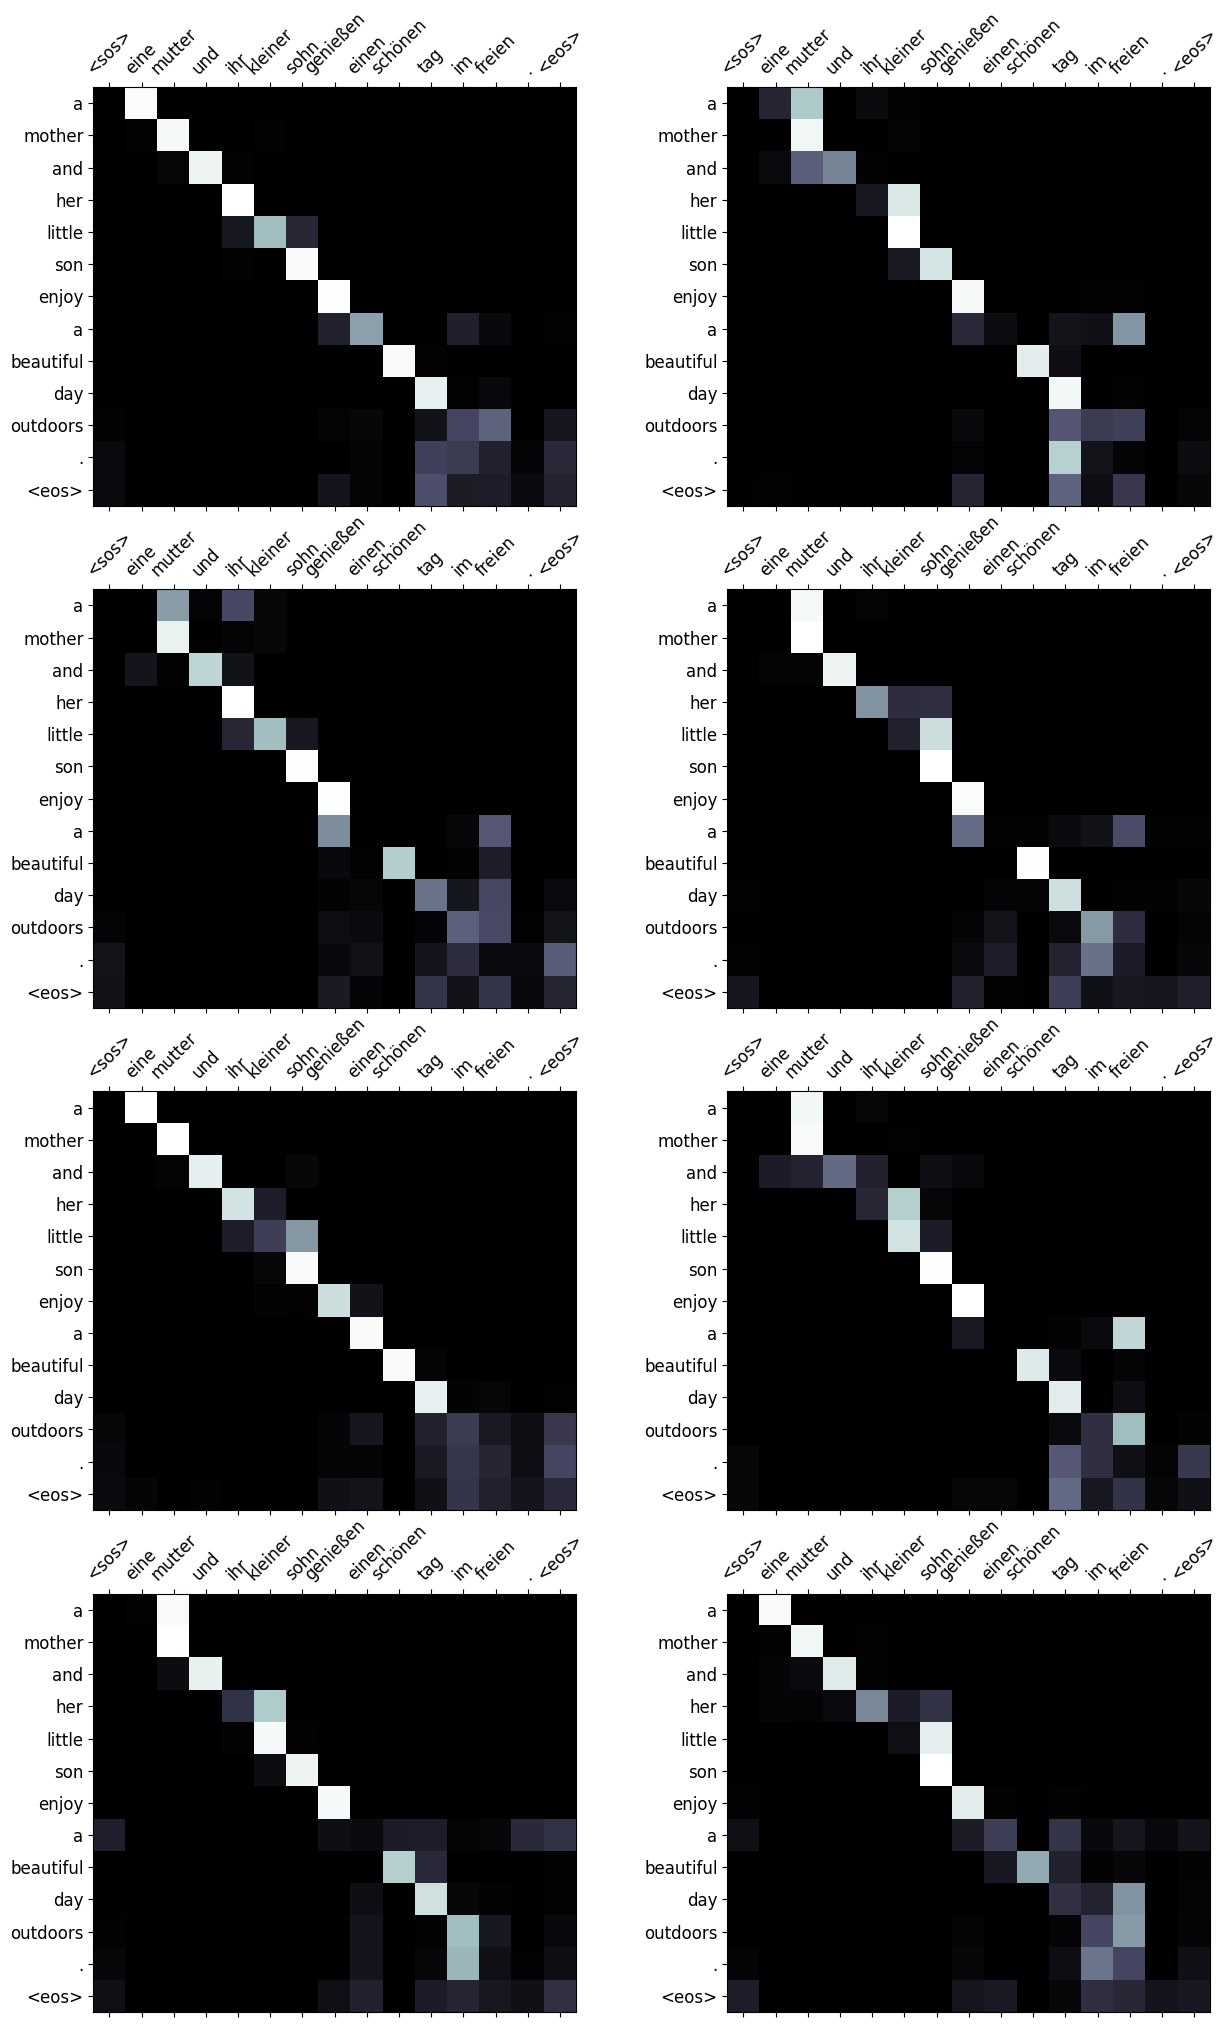

In [48]:
display_attention(src, translation, attention)

## BLEU

Finally we calculate the BLEU score for the Transformer.

In [49]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

We get a BLEU score of 36.52, which beats the ~34 of the convolutional sequence-to-sequence model and ~28 of the attention based RNN model. All this whilst having the least amount of parameters and the fastest training time!

In [50]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 35.94


### Multiple Experiments changing hyperparameters

| Experiments | Batch size | Learning rate | Best Epoch | Val loss | Test loss | BLEU Score |
| --- | --- | --- | --- | -: | -: | -: |
| 1 | 128 | 0.0005 | 8 | **1.615** | **1.661** | **35.94** |
| 2 | 256 | 0.0005 | 8 | 1.645 |1.695 | 35.20 |
| 3 | 512 | 0.0005 | 13 | 1.711 |1.794 | 34.42 |
| 4 | 128 | 0.0001 | 24 | 1.723 |1.804 | 34.74 |
| 5 | 128 | 0.001 | 7 | 1.722 |1.743 | 32.47 |

Congratulations for finishing these tutorials! I hope you've found them useful.

If you find any mistakes or want to ask any questions about any of the code or explanations used, feel free to submit a GitHub issue and I will try to correct it ASAP.

## Appendix

The `calculate_bleu` function above is unoptimized. Below is a significantly faster, vectorized version of it that should be used if needed. Credit for the implementation goes to [@azadyasar](https://github.com/azadyasar).

In [51]:
def translate_sentence_vectorized(src_tensor, src_field, trg_field, model, device, max_len=50):
    assert isinstance(src_tensor, torch.Tensor)

    model.eval()
    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)
    # enc_src = [batch_sz, src_len, hid_dim]

    trg_indexes = [[trg_field.vocab.stoi[trg_field.init_token]] for _ in range(len(src_tensor))]
    # Even though some examples might have been completed by producing a <eos> token
    # we still need to feed them through the model because other are not yet finished
    # and all examples act as a batch. Once every single sentence prediction encounters
    # <eos> token, then we can stop predicting.
    translations_done = [0] * len(src_tensor)
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        pred_tokens = output.argmax(2)[:,-1]
        for i, pred_token_i in enumerate(pred_tokens):
            trg_indexes[i].append(pred_token_i)
            if pred_token_i == trg_field.vocab.stoi[trg_field.eos_token]:
                translations_done[i] = 1
        if all(translations_done):
            break

    # Iterate through each predicted example one by one;
    # Cut-off the portion including the after the <eos> token
    pred_sentences = []
    for trg_sentence in trg_indexes:
        pred_sentence = []
        for i in range(1, len(trg_sentence)):
            if trg_sentence[i] == trg_field.vocab.stoi[trg_field.eos_token]:
                break
            pred_sentence.append(trg_field.vocab.itos[trg_sentence[i]])
        pred_sentences.append(pred_sentence)

    return pred_sentences, attention

In [52]:
from torchtext.data.metrics import bleu_score

def calculate_bleu_alt(iterator, src_field, trg_field, model, device, max_len = 50):
    trgs = []
    pred_trgs = []
    with torch.no_grad():
        for batch in iterator:
            src = batch.src
            trg = batch.trg
            _trgs = []
            for sentence in trg:
                tmp = []
                # Start from the first token which skips the <start> token
                for i in sentence[1:]:
                    # Targets are padded. So stop appending as soon as a padding or eos token is encountered
                    if i == trg_field.vocab.stoi[trg_field.eos_token] or i == trg_field.vocab.stoi[trg_field.pad_token]:
                        break
                    tmp.append(trg_field.vocab.itos[i])
                _trgs.append([tmp])
            trgs += _trgs
            pred_trg, _ = translate_sentence_vectorized(src, src_field, trg_field, model, device)
            pred_trgs += pred_trg
    return pred_trgs, trgs, bleu_score(pred_trgs, trgs)